# Demo
A demonstration notebook showing off how to use the `dmv.data.DataContainer` and the `dmv.layer.DynamicMultiViewRNN`.

In [7]:
import os
import datetime
import seaborn as sb
import numpy as np
import random
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

## Settings

In [9]:
data_folder = Path(r'C:\Users\jeroe\data\MURA\MURA-v1.1')
multi = True
img_shape = [128, 128, 3]

## Augmentation

In [11]:
train_augmentation = {
    'rotation': 30,
    'horizontal_flip': True,
}

## Data

In [42]:
from dmv.data import DataContainer

train_dc = DataContainer(data_folder, train=True, multi=multi, batch_size=8, output_shape=img_shape, augmentation=train_augmentation)
valid_dc = DataContainer(data_folder, train=False, multi=multi, batch_size=8, output_shape=img_shape)

In [44]:
d = train_dc.df
d = d[d['location'].isin(['Humerus', 'Shoulder', 'Wrist'])]
d['img_count'] = d['file'].str.len()
d = d[['location', 'img_count']]
d

D:\Files\Documents\Anaconda\envs\capita\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,location,img_count
8321,Shoulder,4
9503,Shoulder,3
7418,Shoulder,2
12506,Wrist,2
6911,Humerus,2
...,...,...
8364,Shoulder,1
12042,Wrist,2
7986,Shoulder,3
9084,Shoulder,4


In [45]:
e = d.groupby(['location', 'img_count']).agg(count=('img_count', 'count')).reset_index()
e

,location,img_count,count
0,Humerus,1,22
1,Humerus,2,487
2,Humerus,3,62
3,Humerus,4,16
4,Humerus,5,4
5,Humerus,6,1
6,Shoulder,1,320
7,Shoulder,2,515
8,Shoulder,3,1004
9,Shoulder,4,904


In [47]:
sb.set()

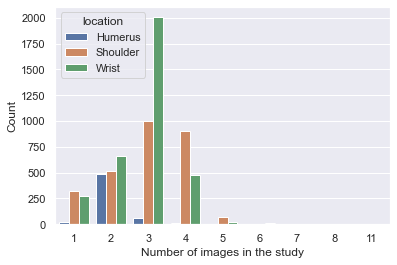

In [57]:
ax = sb.barplot(data=e, x='img_count', y='count', hue='location')
plt.ylabel("Count")
plt.xlabel("Number of images in the study")
plt.savefig('tmp.png')